In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn.functional as F
import torch

from common import metrics

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [ ]:
import torch.nn.functional as F

def cm_win(winsize: int):
    labels = torch.tensor([
        [0, 0, 0, 1, 0, 0, 0], 
        [0, 1, 0, 0, 0, 0, 0], 
        [0, 1, 1, 0, 0, 0, 0]
    ])
    print(labels, labels.size())
    labels = labels.flatten()

    gt_labels = torch.tensor([
        [0, 0, 0, 0, 1, 0, 0], 
        [0, 0, 0, 0, 0, 1, 0], 
        [0, 1, 0, 0, 0, 0, 0]
    ])
    print(gt_labels, gt_labels.size())
    
    print(metrics._skm.confusion_matrix(gt_labels.flatten(), labels))

    indexes = (gt_labels == 1).nonzero()
    print(indexes, indexes.size())

    gt_w = gt_labels.clone()
    for x, y in indexes:
        for i in range(-winsize, winsize+1):
            if 0 <= y+i < gt_labels.size(1):
                gt_w[x, y+i] = 1
    print(gt_w, gt_w.size())

    print(metrics._skm.confusion_matrix(gt_w.flatten(), labels))
    print(metrics._skm.confusion_matrix(1 - gt_w.flatten(), 1 - labels))


cm_win(2)

tensor([[0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0]])
[8 8] [0 0]
[0 0] [2 2]
(100,) (100,) (100,)
(100,) (100,) (100,)


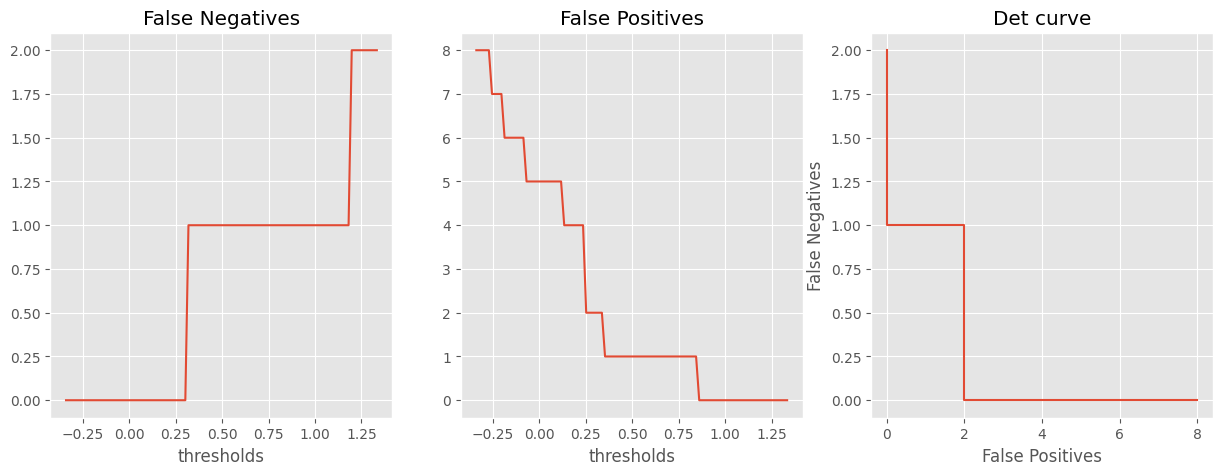

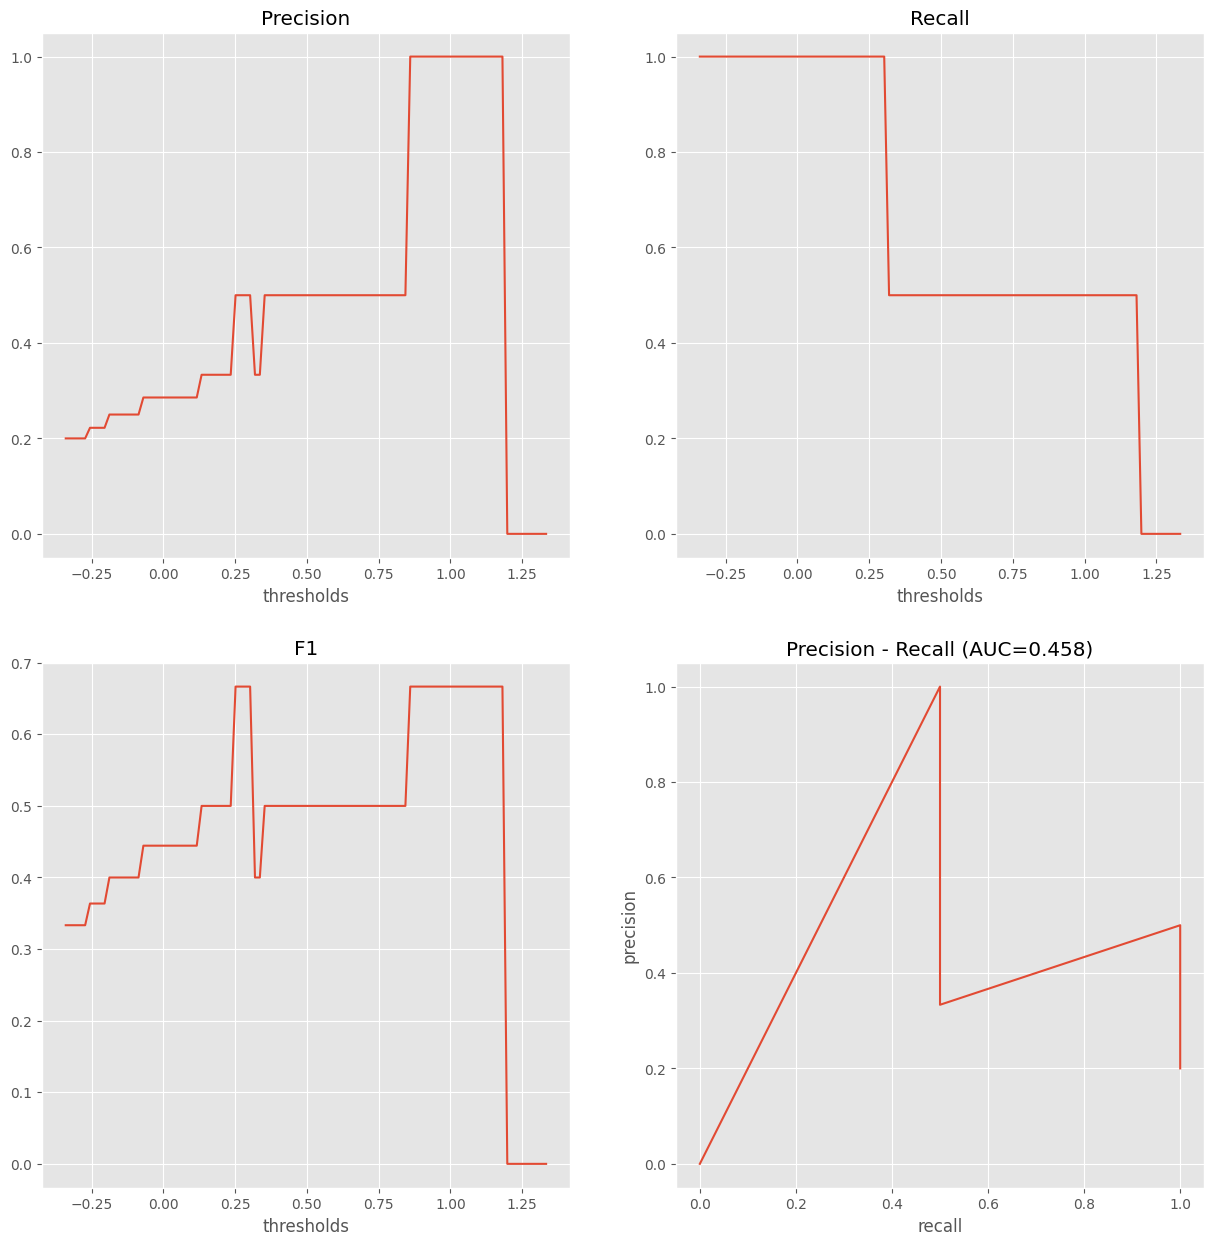

In [36]:
def cm_win(winsize: int):
    signals = torch.tensor(
        [
            [0.13, -0.08, -0.34, 1.35, 0.09, -0.27, 0.06],
            [-0.19, 0.85, 0.24, 0.31, -0.05, -0.08, -0.08],
            [-0.03, 0.68, 1.19, 0.15, 0.25, -0.27, 0.35],
        ],
        dtype=torch.float64,
    )
    gt_labels = torch.tensor(
        [[0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0, 0]]
    )

    print(metrics.fill_tolerance(gt_labels, 2))


    fp, fn, th = metrics.errors_curve(signals, gt_labels, winsize)
    pr, rc, f1 = metrics.precision_recall_f1(fp, fn)

    print(fp[:2], fp[-2:])
    print(fn[:2], fn[-2:])
    print(fp.shape, fn.shape, th.shape)
    print(pr.shape, rc.shape, f1.shape)
    metrics.plot_errors_curve(fp, fn, th)
    metrics.plot_precision_recall_f1_curve(pr, rc, f1, th)


cm_win(2)

In [ ]:
from common.metrics import np, Tensor, fill_tolerance, Tuple

def errors_curve(
    signals: Tensor, labels: Tensor, tolerance: int, num_thrs: int = 100
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    y_score = signals.cpu()
    y_true = labels.cpu()
    y_true_full = fill_tolerance(y_true, tolerance)

    mn, mx = y_score.min(), y_score.max()
    step = (mx - mn) / num_thrs
    thrs = np.arange(mn, mx, step)

    fps = []
    fns = []
    for th in thrs:
        preds: Tensor = (y_score > th).to(y_true.dtype)
        preds_full = fill_tolerance(preds, tolerance)
        fps.append(((1 - y_true_full) * preds).sum().item())
        fns.append((y_true * (1 - preds_full)).sum().item())

    fps = np.asarray(fps)
    fns = np.asarray(fns)

    return fps, fns, thrs

In [37]:
bs = 32
wl = 1024

def cm_win(winsize: int):
    signals = torch.rand(bs, wl)
    gt_labels = (torch.rand_like(signals) > 0.99).to(torch.int)

    print(gt_labels.sum())
    fp, fn, th = metrics.errors_curve(signals, gt_labels, winsize)
    # pr, rc, f1 = metrics.precision_recall_f1(fp, fn)

    metrics.plot_errors_curve(fp, fn, th)
    # metrics.plot_precision_recall_f1_curve(pr, rc, f1, th)


cm_win(12)

tensor(317)


KeyboardInterrupt: 